In [1]:
from torch_geometric.nn import Node2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import os.path as osp
from torch_geometric.datasets import Planetoid
import torch
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,           # Graph edge list (edge index)
    embedding_dim=128,         # Size of each node embedding vector
    walk_length=20,            # Number of nodes in each random walk
    context_size=10,           # Size of the context window (Skip-Gram model window)
    walks_per_node=20,         # Number of random walks to start at each node
    num_negative_samples=1,    # Number of negative samples for each positive sample (for negative sampling)
    p=200,                     # Return parameter (higher means lower probability to return to previous node)
    q=1,                       # In-out parameter (controls likelihood of exploring new nodes)
    sparse=True                # Use sparse gradient updates (memory efficient for large graphs)
).to(device)                   # Move the model to the specified device (CPU or GPU)


In [2]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [3]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [4]:
idx

0

In [5]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [6]:
pos_rw

tensor([[1393, 1371, 1393,  ..., 1371, 1393, 1371],
        [1362, 1914,  778,  ..., 2217,  175,  596],
        [2186, 1692, 2302,  ..., 1469,  756,  172],
        ...,
        [1378, 1544, 1378,  ..., 1378, 1544, 1378],
        [ 251,  253,  507,  ..., 1942,  150, 1942],
        [1344,  724, 2394,  ..., 1199,  881, 1155]])

In [7]:
neg_rw

tensor([[1393, 2547, 1967,  ..., 2292, 2059,  503],
        [1362, 2166,   12,  ...,  222,  507, 1296],
        [2186, 1652, 2499,  ..., 2586, 1127, 2537],
        ...,
        [2152, 1080,  178,  ..., 1436,  330, 1766],
        [1811, 2581,  138,  ...,  189,  387, 1608],
        [ 625, 1456, 1823,  ...,  811, 2372, 1335]])

In [8]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

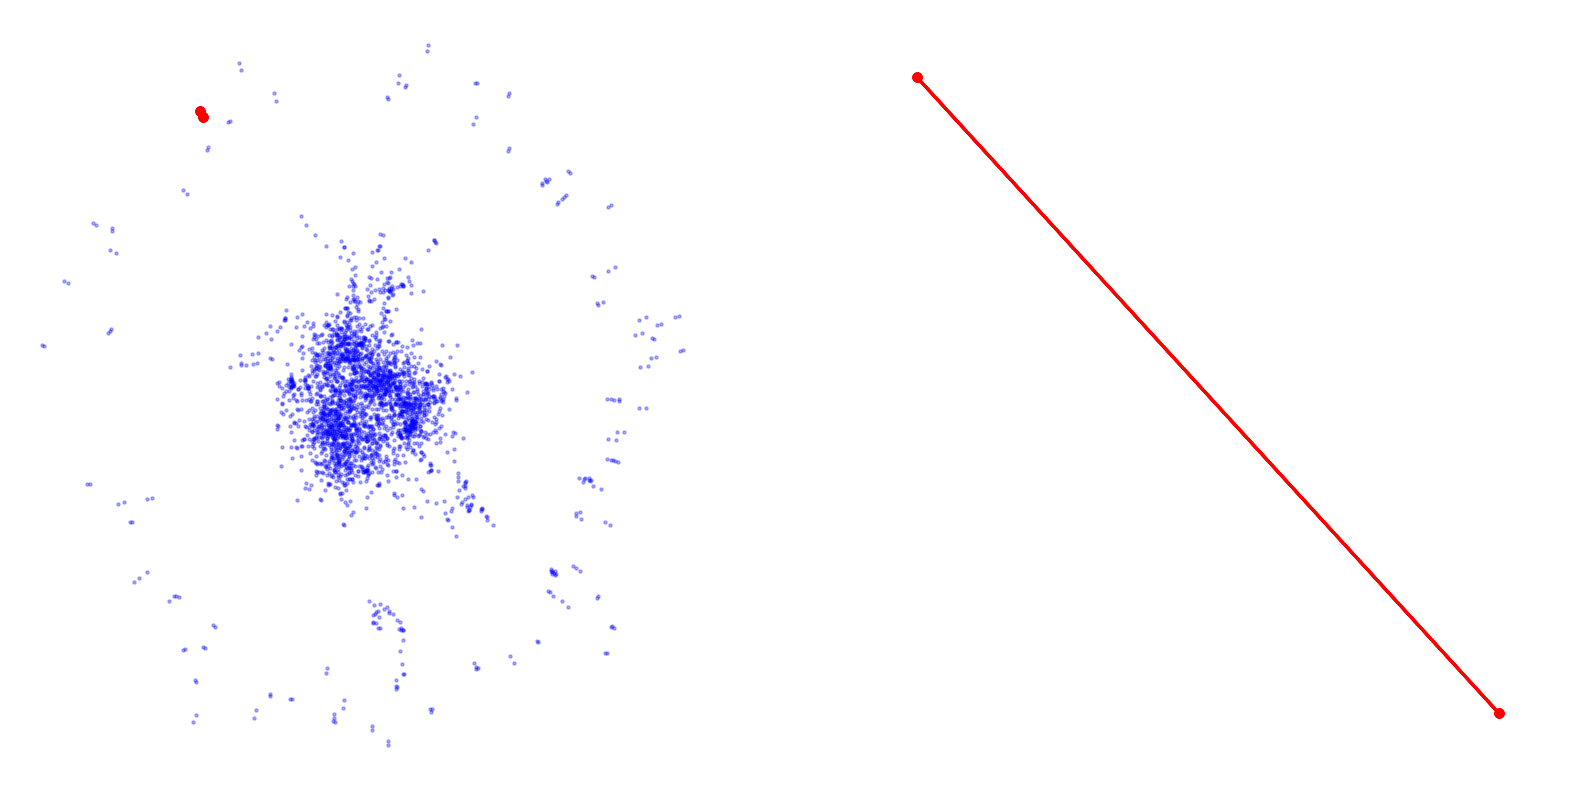

In [9]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

In [10]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [11]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [12]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [14]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [15]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [ ]:
for epoch in range(1, 200):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.1121, Acc: 0.1470


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02, Loss: 6.0615, Acc: 0.1720


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.9470, Acc: 0.1920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.1315, Acc: 0.2340


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.4801, Acc: 0.2710


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06, Loss: 2.9605, Acc: 0.3010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07, Loss: 2.5427, Acc: 0.3320


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08, Loss: 2.2153, Acc: 0.3610


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.9508, Acc: 0.3970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.7416, Acc: 0.4310


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.5699, Acc: 0.4620


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.4278, Acc: 0.4850


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.3188, Acc: 0.5060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.2345, Acc: 0.5300


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.1645, Acc: 0.5570


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.1062, Acc: 0.5780


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.0601, Acc: 0.6000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.0246, Acc: 0.6130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.9966, Acc: 0.6260


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.9739, Acc: 0.6340


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.9540, Acc: 0.6380


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.9373, Acc: 0.6480


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.9231, Acc: 0.6570


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.9128, Acc: 0.6510


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.9013, Acc: 0.6620


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.8943, Acc: 0.6770


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.8873, Acc: 0.6850


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.8805, Acc: 0.6880


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.8769, Acc: 0.6880


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.8721, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.8673, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.8637, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.8611, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.8577, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.8547, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.8522, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.8493, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.8493, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.8472, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.8451, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.8438, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.8430, Acc: 0.7190


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.8414, Acc: 0.7170


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.8396, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.8374, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.8381, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.8371, Acc: 0.7150


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.8362, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.8368, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.8346, Acc: 0.7220


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.8342, Acc: 0.7220


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.8348, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.8335, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.8329, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.8315, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.8304, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.8315, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.8308, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.8305, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.8313, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.8289, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.8298, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.8286, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.8284, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.8282, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.8278, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.8278, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.8272, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.8276, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.8279, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.8262, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.8262, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.8275, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.8262, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.8280, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.8270, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.8268, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.8266, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.8265, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.8267, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.8261, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.8247, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.8253, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.8254, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.8245, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.8256, Acc: 0.6890


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.8261, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.8250, Acc: 0.6850


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.8258, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.8240, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.8259, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.8253, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.8248, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.8251, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.8245, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.8259, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.8244, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.8247, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.8255, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 100, Loss: 0.8242, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 101, Loss: 0.8253, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 102, Loss: 0.8262, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 103, Loss: 0.8245, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 104, Loss: 0.8229, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 105, Loss: 0.8246, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 106, Loss: 0.8243, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 107, Loss: 0.8253, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 108, Loss: 0.8244, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 109, Loss: 0.8245, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 110, Loss: 0.8253, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 111, Loss: 0.8261, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 112, Loss: 0.8241, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 113, Loss: 0.8260, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 114, Loss: 0.8242, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 115, Loss: 0.8253, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 116, Loss: 0.8250, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 117, Loss: 0.8235, Acc: 0.6910


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 118, Loss: 0.8253, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 119, Loss: 0.8247, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 120, Loss: 0.8253, Acc: 0.6890


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 121, Loss: 0.8255, Acc: 0.6900


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 122, Loss: 0.8248, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 123, Loss: 0.8258, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 124, Loss: 0.8240, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 125, Loss: 0.8243, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 126, Loss: 0.8236, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 127, Loss: 0.8241, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 128, Loss: 0.8234, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 129, Loss: 0.8249, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 130, Loss: 0.8251, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 131, Loss: 0.8243, Acc: 0.6880


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 132, Loss: 0.8235, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 133, Loss: 0.8231, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 134, Loss: 0.8249, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 135, Loss: 0.8250, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 136, Loss: 0.8249, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 137, Loss: 0.8235, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 138, Loss: 0.8241, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 139, Loss: 0.8236, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 140, Loss: 0.8245, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 141, Loss: 0.8250, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 142, Loss: 0.8241, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 143, Loss: 0.8246, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 144, Loss: 0.8246, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 145, Loss: 0.8254, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 146, Loss: 0.8245, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 147, Loss: 0.8229, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 148, Loss: 0.8247, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 149, Loss: 0.8245, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 150, Loss: 0.8241, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 151, Loss: 0.8252, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 152, Loss: 0.8246, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 153, Loss: 0.8242, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 154, Loss: 0.8249, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 155, Loss: 0.8249, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 156, Loss: 0.8250, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 157, Loss: 0.8242, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 158, Loss: 0.8242, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 159, Loss: 0.8247, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 160, Loss: 0.8242, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 161, Loss: 0.8245, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 162, Loss: 0.8249, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 163, Loss: 0.8247, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 164, Loss: 0.8251, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 165, Loss: 0.8244, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 166, Loss: 0.8249, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 167, Loss: 0.8245, Acc: 0.7230


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 168, Loss: 0.8247, Acc: 0.7210


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 169, Loss: 0.8246, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 170, Loss: 0.8247, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 171, Loss: 0.8246, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 172, Loss: 0.8240, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 173, Loss: 0.8231, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 174, Loss: 0.8257, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 175, Loss: 0.8253, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 176, Loss: 0.8253, Acc: 0.7210


  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)